In [8]:
import json
import pandas as pd
import torch
import unicodedata
import re
from thefuzz import fuzz, process 
from torch.utils.data import Dataset
from transformers import (
    XLMRobertaTokenizer, 
    XLMRobertaForSequenceClassification, 
    Trainer, 
    TrainingArguments
)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import evaluate
import numpy as np
import warnings

In [9]:
warnings.filterwarnings("ignore", category=UserWarning)

In [10]:
# Load intent data
with open("intent-question.json", "r", encoding="utf-8") as f:
    intent_data = json.load(f)

In [11]:
# Flatten the dataset
flattened_data = []
for entry in intent_data:
    intent = entry["intent"]
    for question in entry["question"]:
        flattened_data.append({"intent": intent, "question": question})


In [12]:
# Convert to DataFrame
df = pd.DataFrame(flattened_data)

# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["intent"])


In [13]:
# Save the label mappings to a JSON file
intent_mapping = dict(zip(df["label"], df["intent"]))
with open("label-mapping.json", "w", encoding="utf-8") as f:
    json.dump(intent_mapping, f, ensure_ascii=False, indent=4)


In [15]:
# Split data into training and validation sets (80% train, 20% validation)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["question"].tolist(), df["label"].tolist(), test_size=0.2, random_state=42
)

In [16]:
# Initialize XLM-RoBERTa tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

# Tokenize the training and validation text data
train_encodings = tokenizer.batch_encode_plus(
    train_texts, 
    truncation=True, 
    padding=True, 
    max_length=64, 
    return_tensors="pt"
)

val_encodings = tokenizer.batch_encode_plus(
    val_texts, 
    truncation=True, 
    padding=True, 
    max_length=64, 
    return_tensors="pt"
)


In [17]:
#Create Custom Dataset Class
from torch.utils.data import Dataset
class IntentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

In [18]:
#Create Datasets
train_dataset = IntentDataset(train_encodings, train_labels)
val_dataset = IntentDataset(val_encodings, val_labels)

In [19]:
# Load Pretrained XLM-RoBERTa Model
num_labels = len(df["intent"].unique())
model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base", num_labels=num_labels
)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    return {"accuracy": accuracy["accuracy"], "f1-score": f1["f1"]}

In [25]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Evaluate every epoch
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    learning_rate=3e-5,
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1-score",
    greater_is_better=True
)

In [ ]:
# training_args = TrainingArguments(
#     output_dir="./results",
#     evaluation_strategy="epoch",
#     per_device_train_batch_size=8,  # Larger batch size for stability
#     per_device_eval_batch_size=8,
#     num_train_epochs=30,
#     learning_rate=1e-5,  # Reduced to stabilize training
#     weight_decay=0.001,  # Less aggressive regularization
#     save_strategy="epoch",
#     logging_dir="./logs",
#     logging_steps=10,
#     load_best_model_at_end=True,
#     metric_for_best_model="f1-score"
# )

In [27]:
# Update Trainer to include compute_metrics
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [28]:
# Train again
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1-score
1,2.897800,2.997941,0.074766,0.010402
2,2.864000,2.764491,0.140187,0.057428
3,2.354400,2.364810,0.252336,0.145977
4,1.846600,1.785695,0.317757,0.225745
5,1.553800,1.402815,0.560748,0.457780
6,1.405900,1.196320,0.542056,0.452472
7,1.139300,0.938665,0.663551,0.613296
8,0.848400,0.750396,0.700935,0.637624
9,0.686200,0.654318,0.813084,0.783917
10,0.587900,0.569929,0.794393,0.763911


TrainOutput(global_step=810, training_loss=1.216676755010346, metrics={'train_runtime': 344.0354, 'train_samples_per_second': 18.53, 'train_steps_per_second': 2.354, 'total_flos': 121233105873000.0, 'train_loss': 1.216676755010346, 'epoch': 15.0})

In [ ]:
# model.save_pretrained("./capstone")
# tokenizer.save_pretrained("./capstone")

# print("Model training complete! Model saved in ./capstone")

Model training complete! Model saved in ./capstone


In [ ]:
import json
import torch
import unicodedata
import re
from rapidfuzz import fuzz, process  # Use RapidFuzz instead of TheFuzz
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizer

#Load Model and Tokenizer
model = XLMRobertaForSequenceClassification.from_pretrained("./capstone")
tokenizer = XLMRobertaTokenizer.from_pretrained("./capstone")

#Load Intent Mapping
with open("label-mapping.json", "r", encoding="utf-8") as f:
    intent_mapping = json.load(f)

# oad Responses from separated_responses.json
with open("newdata.json", "r", encoding="utf-8") as f:
    response_list = json.load(f)

#Improved Khmer Text Cleaning
def clean_text(text):
    """Normalize Khmer text, remove extra spaces, and filter non-Khmer characters"""
    text = unicodedata.normalize("NFC", text).strip()
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[^\u1780-\u17FF\s]", "", text) 
    return text.lower()

#Improved RapidFuzz Matching
def fuzzy_match(keyword, question, threshold=75):
    """Match keywords using RapidFuzz with a stricter threshold"""
    return fuzz.partial_ratio(keyword, question) >= threshold

#Improved Intent Classification
def predict_intent(question):
    """Predict the intent of the user's question using XLM-RoBERTa"""
    inputs = tokenizer(question, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    predicted_label = torch.argmax(outputs.logits, dim=1).item()
    intent = intent_mapping.get(str(predicted_label), "UnknownIntent")
    
    print(f"Intent Identified: {intent}")  # Debugging
    return intent

#Improved Response Retrieval with Best Matching (Using RapidFuzz)
from rapidfuzz import process, fuzz

#Improved Response Retrieval with Best Matching (Using RapidFuzz)
def get_response(intent, question):
    """Retrieve the best response based on intent and improved keyword matching"""
    cleaned_question = clean_text(question)

    #Filter responses for this intent
    filtered_responses = [item for item in response_list if item["intent"] == intent]

    if not filtered_responses:
        print(f"No responses found for Intent '{intent}'")
        return "សុំទោស ខ្ញុំមិនអាចឆ្លើយសំណួរនេះបាន។"

    print(f"Found {len(filtered_responses)} possible answers for Intent: {intent}")

    #Extract the best-matching keyword
    keywords = [clean_text(item["keyword"]) for item in filtered_responses]

    # Corrected code here for `process.extractOne`
    result = process.extractOne(cleaned_question, keywords, scorer=fuzz.partial_ratio)

    if result:  
        best_match, best_score = result[0], result[1]  # Now unpack correctly
        #print(f"Best match: {best_match}, Score: {best_score}")  # Debugging output
    else:
        best_match, best_score = None, 0  

    if best_score >= 50:
        #Find the corresponding answer
        for item in filtered_responses:
            if clean_text(item["keyword"]) == best_match:
                return item["answer"]

    return "សុំទោស ខ្ញុំមិនមានសម្ថភាពអាចឆ្លើយសំណួរនេះបាន។"


#test the chatbot
def chatbot_response(user_question):
    intent = predict_intent(user_question)
    return get_response(intent, user_question)

In [ ]:
#Example Test
user_question ="ទុំជានរណាគេ"

predicted_intent = predict_intent(user_question)

bot_response = get_response(predicted_intent, user_question)
print(f"🤖 Chatbot Response: {bot_response}")

Intent Identified: AskAboutCharacterRoleTumTeav
Found 4 possible answers for Intent: AskAboutCharacterRoleTumTeav
🤖 Chatbot Response: ទុំជាកូនប្រុសរបស់ស្រ្តីមេម៉ាយម្នាក់បានបួសជាសាមណេររៀននៅវត្តវិហារធំ ស្រុកបាភ្នំ ខេត្តព្រៃវែងជាមួយមិត្តភក្តិម្នាក់ឈ្មោះ ពេជ្រ។ ទាំងពីរនាក់មានចំណេះដឹងខាងមន្តអាគម ស្មូត្រ ផ្លុំប៉ី និងធ្វើតោកលក់។


<Axes: xlabel='intent'>

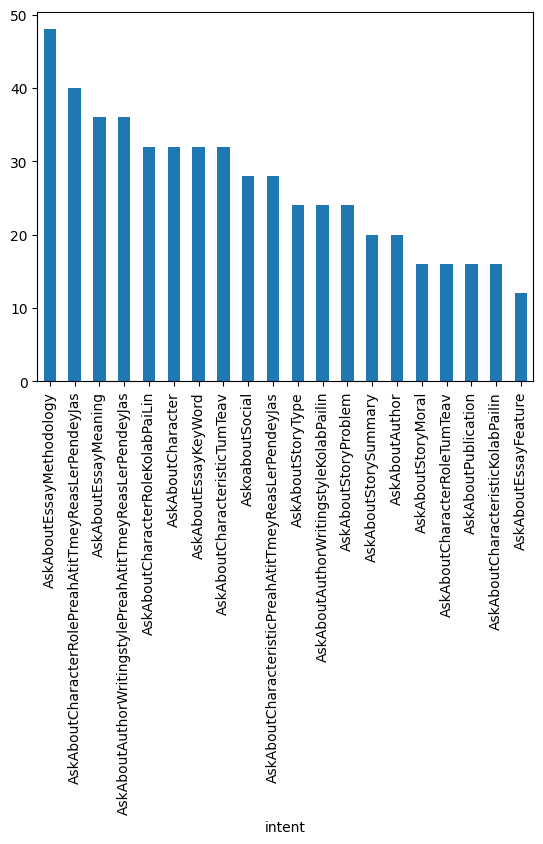

In [ ]:
df["intent"].value_counts().plot(kind="bar")

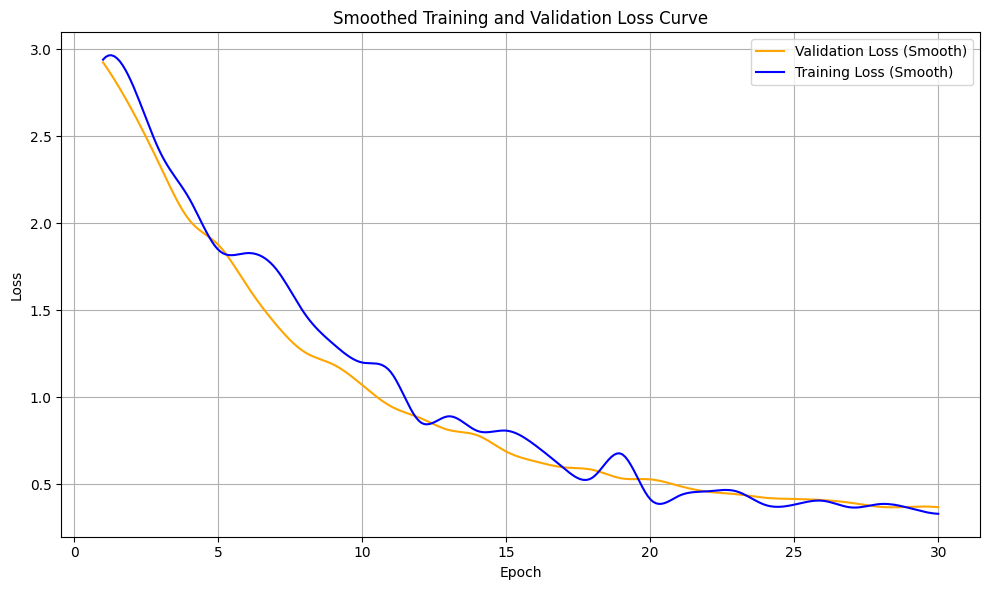

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Epochs
epochs = np.array(list(range(1, 31)))

# Training and validation loss
train_loss = np.array([
    2.9393, 2.8058, 2.4020, 2.1395, 1.8474, 1.8279, 1.7387, 1.4806, 1.3054, 1.1992,
    1.1426, 0.8592, 0.8905, 0.8062, 0.8080, 0.7248, 0.5924, 0.5388, 0.6746, 0.4142,
    0.4337, 0.4595, 0.4590, 0.3809, 0.3828, 0.4050, 0.3665, 0.3865, 0.3631, 0.3303
])

val_loss = np.array([
    2.9239, 2.6514, 2.3232, 2.0170, 1.8756, 1.6407, 1.4193, 1.2595, 1.1877, 1.0700,
    0.9472, 0.8815, 0.8119, 0.7810, 0.6879, 0.6316, 0.5972, 0.5827, 0.5339, 0.5282,
    0.4907, 0.4572, 0.4427, 0.4222, 0.4155, 0.4090, 0.3927, 0.3699, 0.3702, 0.3682
])

# Smoothing
x_smooth = np.linspace(epochs.min(), epochs.max(), 300)  # Smooth x-axis

train_spline = make_interp_spline(epochs, train_loss, k=3)
val_spline = make_interp_spline(epochs, val_loss, k=3)

train_loss_smooth = train_spline(x_smooth)
val_loss_smooth = val_spline(x_smooth)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, val_loss_smooth, label='Validation Loss (Smooth)', color='orange')
plt.plot(x_smooth, train_loss_smooth, label='Training Loss (Smooth)', color='blue')
plt.title('Smoothed Training and Validation Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
